# Evaluation of ChestX

Comparison of the effect of various Positional Encodings on ViTs performance on chest x-ray multi-label classification task.  
There are 20 labels to be predicted with large class imbalance.

This notebook contains
1. Basic dataset overview
2. Predictions on test data
3. Performance metric overview
4. Significance testing
5. Per class performance comparison of top two models

In [13]:
# Basic i/o
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm

# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt

# Data analysis
import numpy as np
import pandas as pd
import torch

# Metrics
from scipy.stats import ttest_rel
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MultilabelAUROC,
    MultilabelAveragePrecision,
    MultilabelF1Score,
    BinaryAUROC,
    BinaryF1Score,
    BinaryAveragePrecision,
    BinaryROC,
    BinaryPrecisionRecallCurve
)
from torchmetrics.wrappers import BootStrapper
from lightning.pytorch import seed_everything

# Dataset and model
from posenc.datasets.chestx import ChestXDataModule
from posenc.modules.vision_transformer import ViTMultiClsModule

# Global settings
sns.set_style("white")
seed_everything(4242)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CHECKPOINT_DIR = Path("../checkpoints/chestx")
RESULTS_PATH = Path("../results/chestx_predictions.csv")

MODELS = {p.parent.name: p for p in CHECKPOINT_DIR.rglob("*.ckpt")}

print("Running on:", DEVICE)

Seed set to 4242


Running on: cpu


## Dataset overview

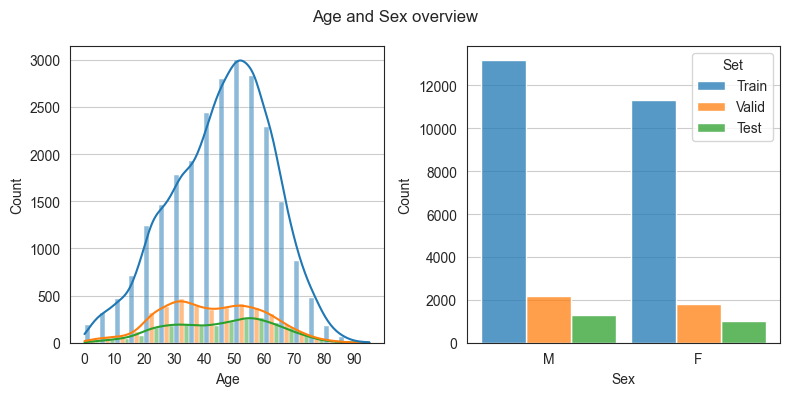

In [14]:
meta_chestx = pd.read_csv("../datasets/Data_Entry_2017_v2020.csv")
train_chestx = pd.read_csv("../datasets/miccai2023_nih-cxr-lt_labels_train.csv")
valid_chestx = pd.read_csv("../datasets/miccai2023_nih-cxr-lt_labels_val.csv")

meta_chestx.loc[meta_chestx["Image Index"].isin(train_chestx["id"]), "Set"] = "Train"
meta_chestx.loc[meta_chestx["Image Index"].isin(valid_chestx["id"]), "Set"] = "Valid"
meta_chestx.loc[meta_chestx["Set"].isna(), "Set"] = "Test"

meta_agg = meta_chestx.loc[:, ["Patient ID", "Patient Age", "Patient Gender", "Set"]].groupby("Patient ID").agg(lambda x: x.mean() if isinstance(x, int) else x.iloc[0])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.suptitle("Age and Sex overview")
sns.histplot(data=meta_agg, x="Patient Age", hue="Set", bins=range(0, 100, 5), multiple="dodge", kde=True, ax=axs[0], legend=False)
axs[0].set_xticks(range(0, 100, 5), [x if x % 10 == 0 else "" for x in range(0, 100, 5)])
axs[0].grid(axis="y")
axs[0].set_xlabel("Age")
sns.histplot(meta_agg, x="Patient Gender", hue="Set", multiple="dodge", shrink=0.9, ax=axs[1])
axs[1].grid(axis="y")
axs[1].set_xlabel("Sex")
plt.tight_layout()
plt.show()

In [15]:
def percentify(x):
    return (np.array(x) / np.sum(x)) * 100

dm = ChestXDataModule("multilabel", csv_root=Path("../datasets"))
dm.setup()

counts = dm.valid.data.iloc[:, 1:21].sum()
labels, counts = counts.index, counts.values
valid_labels, valid_counts = zip(
    *sorted(zip(labels, counts), key=lambda x: x[1], reverse=True)
)
valid_counts = percentify(valid_counts)

counts = dm.train.data.iloc[:, 1:21].sum()
labels, counts = counts.index, counts.values
train_labels, train_counts = zip(
    *sorted(zip(labels, counts), key=lambda x: x[1], reverse=True)
)
train_counts = percentify(train_counts)

counts = dm.test.data.iloc[:, 1:21].sum()
labels, counts = counts.index, counts.values
test_labels, test_counts = zip(
    *sorted(zip(labels, counts), key=lambda x: x[1], reverse=True)
)
test_counts = percentify(test_counts)

combined_data = pd.DataFrame(
    {
        "Label": list(train_labels) + list(valid_labels) + list(test_labels),
        "Count": list(train_counts) + list(valid_counts) + list(test_counts),
        "Dataset": ["Training"] * len(train_counts)
        + ["Validation"] * len(valid_counts) + ["Test"] * len(test_counts),
    }
)

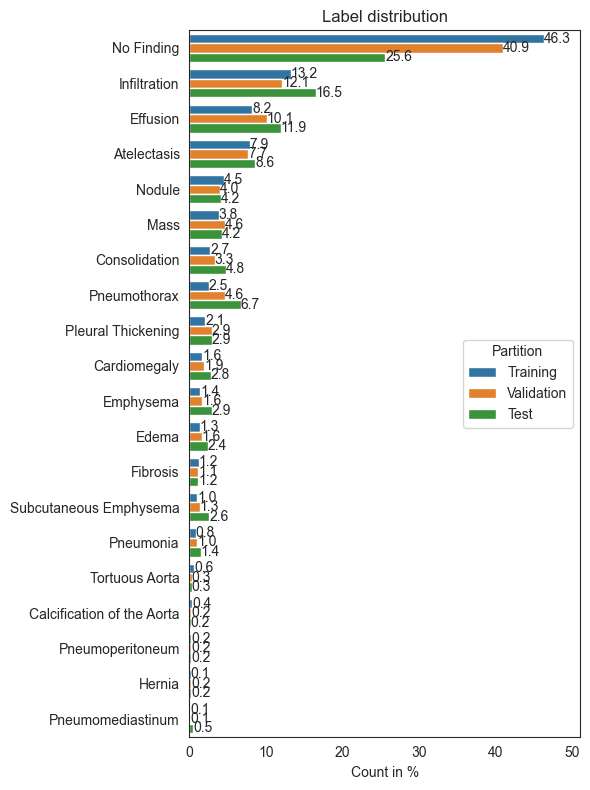

In [16]:
plt.figure(figsize=(6, 8))
plt.title("Label distribution")
ax = sns.barplot(data=combined_data, y="Label", x="Count", hue="Dataset")
ax.bar_label(ax.containers[0], fontsize=10, fmt="{:.1f}")
ax.bar_label(ax.containers[1], fontsize=10, fmt="{:.1f}")
ax.bar_label(ax.containers[2], fontsize=10, fmt="{:.1f}")
plt.ylabel("")
plt.xlim(0, 51)
plt.xlabel("Count in %")
plt.legend(loc="center right", title="Partition")
plt.tight_layout()
plt.show()

## Prediction on test data

In [17]:
@torch.no_grad()
def predict(model, loader):
    """Prediction generator given a dataloader and model."""
    model.eval()
    for (x, y) in tqdm(loader):
        y_hat = model(x.to(DEVICE)).cpu()
        yield y_hat.flatten(), y.flatten()

def generate_results(save_path=None, num_workers=32):
    """Takes a model_name:model_path dictonary and an output path to generate results."""

    chestx = ChestXDataModule(
        task="multilabel", batch_size=128, num_workers=num_workers, do_cutmix=False, do_mixup=False
    )
    chestx.setup()
    loader = chestx.test_dataloader()
    
    res = defaultdict(list)
    for model_name, path in MODELS.items():

        model_path = CHECKPOINT_DIR / path
        torch.manual_seed(4242)
        model = ViTMultiClsModule.load_from_checkpoint(model_path, map_location=torch.device(DEVICE))
        
        print("Evaluating", model_name)
        total_samples = 0
        for y_hat, y in predict(model, loader):
            n_labels = len(y_hat)
            n_samples = n_labels // 20
            
            res["logits"] += y_hat.tolist()
            res["pred"] += y_hat.sigmoid().tolist()
            res["model"] += [model_name] * n_labels
            res["y"] += y.tolist()
            res["label"] += chestx.test.labels * n_samples
            # y has shape (samples, 20). We keep track of what sample every class prediction belongs to.
            res["sample"] += np.repeat(np.arange(total_samples, total_samples + n_samples), 20).tolist()
            total_samples += n_samples

    df = pd.DataFrame(res)

    if save_path is not None:
        df.to_csv(save_path)

    return df

In [18]:
if RESULTS_PATH.is_file():
    df = pd.read_csv(RESULTS_PATH, index_col=0)
else:
    df = generate_results(save_path=RESULTS_PATH, num_workers=32)

## Performance metric overivew

In [19]:
metric_collection = MetricCollection({
    "mAP":   BootStrapper(MultilabelAveragePrecision(num_labels=20), num_bootstraps=100), # Suited metric!
    "F1":    BootStrapper(MultilabelF1Score(num_labels=20), num_bootstraps=3), # Not recommended, because of single threshold!
    "AUROC": BootStrapper(MultilabelAUROC(num_labels=20), num_bootstraps=3) # Not recommended, because of class imbalance!
})

results = defaultdict(list)

for model, group in tqdm(df.groupby("model")):
    # Convert to tensors
    y_true = torch.tensor(group.pivot(index="sample", columns="label", values="y").values, dtype=torch.int)
    y_pred = torch.tensor(group.pivot(index="sample", columns="label", values="pred").values, dtype=torch.float)
    
    # Re-seeding before calling metric_collection(y_pred, y_true) 
    # ensures that any random sampling done within BootStrapper is deterministic
    torch.manual_seed(4242)  
    
    # Compute metrics
    metrics = metric_collection(y_pred, y_true)
    
    # Save metrics
    for metric in metric_collection.keys():
        results["metric"].append(metric)
        results["mean"].append(metrics[f"{metric}_mean"].item())
        results["std"].append(metrics[f"{metric}_std"].item())
        results["model"].append(model)

results = pd.DataFrame(results)

100%|██████████| 6/6 [01:22<00:00, 13.67s/it]


In [20]:
best_models = results[results.metric == "mAP"].sort_values("mean", ascending=False).reset_index(drop=True)
best_models.round(3)

,metric,mean,std,model
0,mAP,0.186,0.003,spe
1,mAP,0.185,0.004,afpe
2,mAP,0.184,0.003,fpe
3,mAP,0.179,0.003,lfpe
4,mAP,0.156,0.002,learnable
5,mAP,0.146,0.002,none


## Significance testing

In [21]:
top_two_models = best_models.model.iloc[:2].values

In [22]:
mAP = BootStrapper(MultilabelAveragePrecision(num_labels=20), num_bootstraps=1000, raw=True)

top_two = []
for model, group in df.groupby("model"):

    if model not in top_two_models:
        continue
    y_true = torch.tensor(group.pivot(index="sample", columns="label", values="y").values, dtype=torch.int)
    y_pred = torch.tensor(group.pivot(index="sample", columns="label", values="pred").values, dtype=torch.float)

    # Compute metrics
    torch.manual_seed(4242)  
    performance = mAP(y_pred, y_true)["raw"]
    top_two.append(performance)

# This test is robust to normality violations if num_bootstraps is large (due to the Central Limit Theorem).
pvalue = ttest_rel(*top_two).pvalue
if pvalue < 0.05:
    print(f"\n The top two models are statistically significantly different from each other (p=={pvalue:.3f}).")
else:
    print(f"\n The top two models are not statistically significantly different from each other (p=={pvalue:.3f}).")


 The top two models are statistically significantly different from each other (p==0.000).


## Per-class performance 

In [23]:
auroc_fn = BinaryAUROC()
f1_fn = BinaryF1Score()
map_fn = BinaryAveragePrecision()

roc = BinaryROC()
pr_curve = BinaryPrecisionRecallCurve()

In [24]:
per_class_results = defaultdict(list)
roc_curves = []
pr_curves = []
for model in top_two_models:
    for label, group in df[df.model == model].groupby("label"):
        y_true = torch.tensor(group.y.values, dtype=torch.int)
        y_pred = torch.tensor(group.pred.values, dtype=torch.float)

        auroc = auroc_fn(y_pred, y_true)
        f1 = f1_fn(y_pred, y_true)
        map_v = map_fn(y_pred, y_true)

        per_class_results["model"].append(model)
        per_class_results["label"].append(label)       
        per_class_results["auroc"].append(auroc.item())
        per_class_results["f1"].append(f1.item())
        per_class_results["map"].append(map_v.item())

        fpr, tpr, thresholds = roc(y_pred, y_true)
        precision, recall, thresholds = pr_curve(y_pred, y_true)

        roc_curves.append((model, label, fpr, tpr))
        pr_curves.append((model, label, precision, recall))

per_class_results = pd.DataFrame(per_class_results)

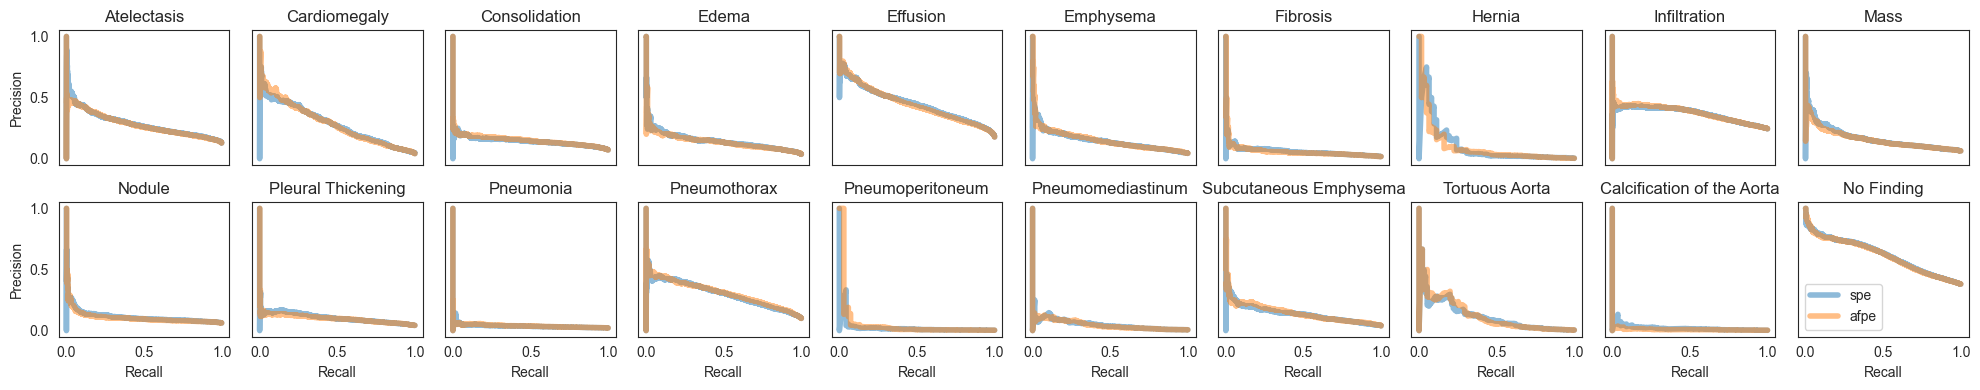

In [25]:
label_to_idx = {l:i for i, l in enumerate(df.label.unique())}

fig, axs = plt.subplots(2, 10, sharex=True, sharey=True)
fig.set_size_inches(20, 4)
for model, label, precision, recall in pr_curves:

    idx = label_to_idx[label]

    col = idx % 10
    row = idx // 10

    
    axs[row, col].plot(recall, precision, lw=4, alpha=0.5, label=model)
    axs[row, col].set_title(label)
    if col == 0:
        axs[row, col].set_ylabel("Precision")
    if row == 1:
        axs[row, col].set_xlabel("Recall")
plt.tight_layout()
plt.legend()
plt.show()


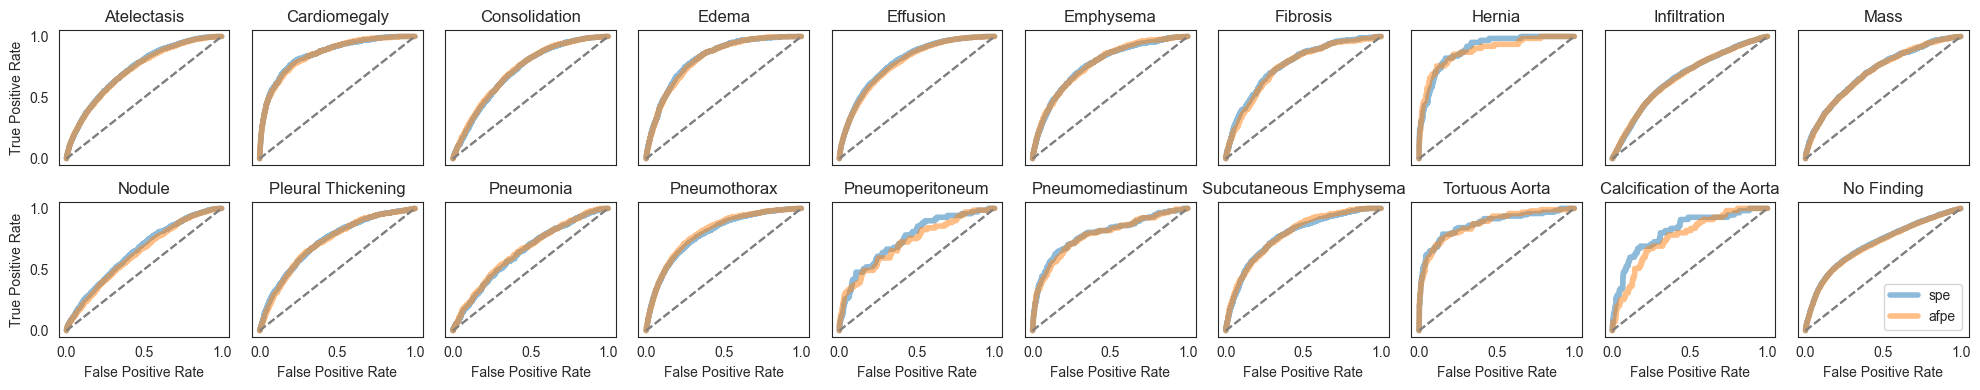

In [26]:
label_to_idx = {l:i for i, l in enumerate(df.label.unique())}

fig, axs = plt.subplots(2, 10, sharex=True, sharey=True)
fig.set_size_inches(20, 4)
for model, label, fpr, tpr in roc_curves:

    idx = label_to_idx[label]

    col = idx % 10
    row = idx // 10

    
    axs[row, col].plot(fpr, tpr, lw=4, alpha=0.5, label=model)
    axs[row, col].set_title(label)
    axs[row, col].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for reference
    if col == 0:
        axs[row, col].set_ylabel("True Positive Rate")
    if row == 1:
        axs[row, col].set_xlabel("False Positive Rate")
plt.tight_layout()
plt.legend()
plt.show()


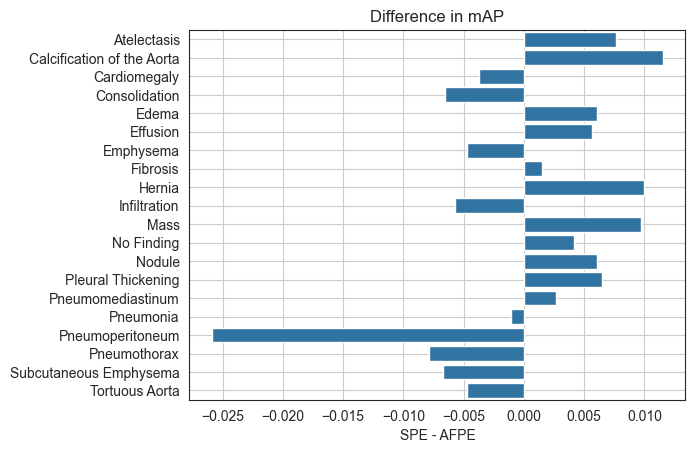

In [27]:
difference = per_class_results.loc[per_class_results.model == "spe", "map"].values - per_class_results.loc[per_class_results.model == "afpe", "map"].values
labels = per_class_results.label.unique()
sns.barplot(x=difference, y=labels)
plt.grid()
plt.title("Difference in mAP")
plt.xlabel("SPE - AFPE")
plt.show()

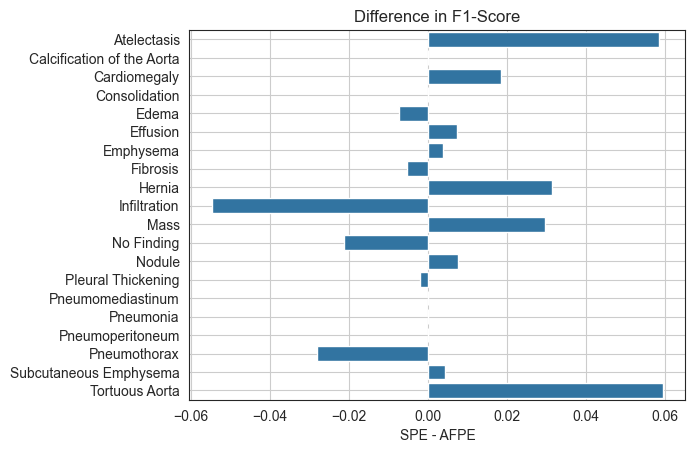

In [28]:
difference = per_class_results.loc[per_class_results.model == "spe", "f1"].values - per_class_results.loc[per_class_results.model == "afpe", "f1"].values
labels = per_class_results.label.unique()
sns.barplot(x=difference, y=labels)
plt.grid()
plt.title("Difference in F1-Score")
plt.xlabel("SPE - AFPE")
plt.show()

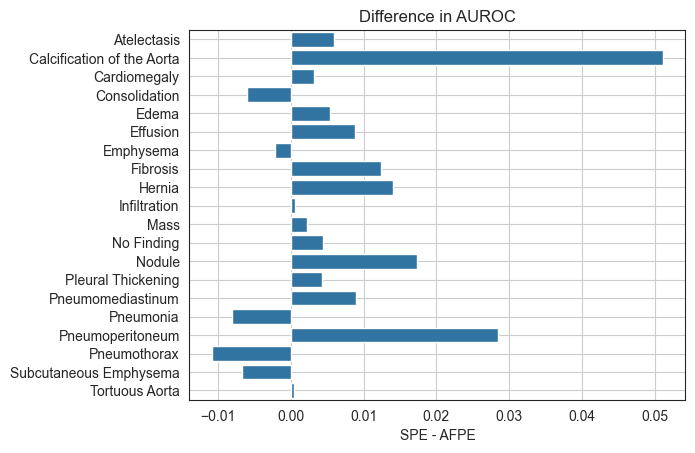

In [29]:
difference = per_class_results.loc[per_class_results.model == "spe", "auroc"].values - per_class_results.loc[per_class_results.model == "afpe", "auroc"].values
labels = per_class_results.label.unique()
sns.barplot(x=difference, y=labels)
plt.grid()
plt.title("Difference in AUROC")
plt.xlabel("SPE - AFPE")
plt.show()